# Marcello Mancino's Deep Learning Motion Deblurring Project [January 2024]

Marcello Mancino - 0001067518

#Motion Deblurring

The project involves deblurring images. The blurred version is obtained through a superposition of slightly translated versions of the same image, following a random trajectory. This kind of blur is supposed to simulate the result of a shot taken with a shaky hand.

In [26]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [27]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

Here i've set the random_seed to make my experiments consistent:
<a id='random_seed'></a>

In [28]:
random_seed = 69
tf.keras.utils.set_random_seed(random_seed)

We work with images obtained from MNIST.

In [29]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

In [30]:
print(x_train.shape)
print(x_test.shape)

train_samples = x_train.shape[0]
test_samples = x_test.shape[0]

(60000, 28, 28)
(10000, 28, 28)


Below there is a generator used to create blurred images starting from normal ones.

In [31]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


In [32]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Below i've created both my training and validation generators.

For the training one i've chosen a batch size of 32 for four reasons:

1. 32 is a power of two, so i'm taking advantage of my GPU's processing.
2. It is a number bigger than 30, that is the smallest number for which the Central Limit Theorem holds.
3. As indicated in this [paper](https://www.sciencedirect.com/science/article/pii/S2405959519303455#:~:text=There%20is%20a%20high%20correlation,size%20with%20low%20learning%20rate.), it is better for convolutional networks (in a generalization perspective) to use small learning rates with small batches.
4. The training set size (60000) is divisible by 32, so since the number of steps per epoch is computed as train_samples / batch_size i'll be able to explore the full dataset in each epoch, without having a last "incomplete" (and thus not performed) step.

For the validation generator i decided to use a different batch size because with bs = 32 the operation test_samples // validation_batch_size would have given an approximated result due to 10000 (test_samples's value) not being divisible by 32 (batch_size's value), and so i would not have considered all 10000 samples as requested (4). 50 is also bigger than 30 so the CLT still holds (2), and it is still a quite small number (3). The only drawback is that it is not a power of 2, so i'm not fully optimizing my GPU processing (1).
   

In [33]:
batch_size = 32
train_gen = generator(x_train, batch_size) 

validation_batch_size = 50  
my_validation_gen = generator(x_test,validation_batch_size)

Here we plot some examples. In the first row you see the blurred image, and in the second the original image, that is the ground truth that you are suppose to obtain through deblurring.

10


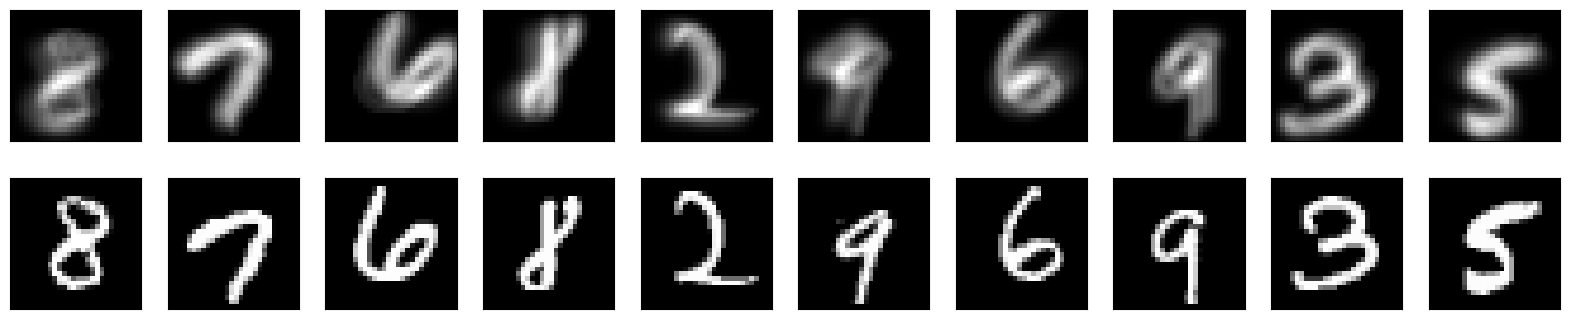

In [34]:
test_x,test_y = next(train_gen)
plot(test_x[:10],test_y[:10])

# Evaluation

I'm going to use Mean Squared Error (mse) to evaluate the error between the deblurred image and the ground truth.
I'll measure mse on 10000 blurred versions of the validation set.

I'll repeat the previous computation 10 times, and will give as a result the **mean
mse over the ten rounds, along with the standard deviation**.

# Getting started: reading some literature

The first thing i've done has been looking for some literature about image deblurring using Deep Learning techniques. The paper that helped me the most, both in grasping the problem at hand and in understanding the most utilised techniques and architectures, has been __[Deep Image Deblurring: a Survey](https://arxiv.org/abs/2201.10700)__ by Zhang et al.

Reading it i discovered that the task i had to solve is known as "Blind Deblurring", since the blur kernel is not fed to the network, and so i started looking for the main architectures that have been developed so far to solve this problem, which are:

1. Deep Auto Encoders (DAE)
2. Generative Adversarial Networks (GAN)
3. Cascaded Networks 
4. Multi-Scale Networks
5. Reblurring Networks

Since i was requested to use mse as loss function, i discarder option (2) given that GANs are trained using the Adversarial Loss, and also option (5) since Reblurring Networks are mostly based on GANs and also because they have the aim to create additional blurred images for training purposes: since a generator that can virtually give me an infinite amount of different training pairs (it is so because the 10 moves it applies every time it is run are random, and so the same image will be blurred almost certainly in a different manner each time it is extracted by the generator from the training set) has already been given to me, i thought that i didn't need further data augmentation. Then i considered option (3) and (4), but since MNIST images have a really coarse resolution (28x28), i came to the conclusion that those architectures were too much complicated for the dataset at hand.

Thus my choice fell on DAEs, so i started reading some papers about their usage for image deblurring and found out __[Dynamic Scene Deblurring with Parameter Selective Sharing and Nested Skip Connections](https://ieeexplore.ieee.org/document/8953950)__ by Gao et al.
They propose an architecture that is composed by several encoder-decoder networks stacked on top of each other, each one processing the image at a different scale. Those encoder-decoder subnetworks are very similar to the U-Net proposed in the eponymous paper __[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)__, with some notable differencies:

1. In each stage of both encoder and decoder, they use 17 convolutional layers, while in U-Net there are only 2
2. Their skip connections are implemented as summations, while in U-Net they are concatenations along the channel axis

Armed with this knowledge, i decided to try out my first, baseline architecture: a simple Encoder/Decoder Network.

# Architecture development: one brick at a time

Note about the following sketches: on the first line of every architecture are indicated the stages in the from "CHARACTER_NUMBER" (apart from the bottleneck that, being only one, has only the "CHARACTER" part). The CHARACTER indicates the kind of stage, while the NUMBER indicates the number of said stage. 
<br>
<br>
The possible CHARACTERS are:
<br>
<br>
E -> Encoder 
<br>
D -> Decoder
<br>
B -> Bottleneck
<br>
<br>
Furthermore, the stacked "|" represent activations: on top of them there is the number of channels, while below them there is a number indicating both the width and the height (we work with square images, so they are alwasy the same).

## Baseline: Encoder/Decoder

The first architecture i devised is a simple one, and it is so because i did not want to introduce a lot of complexity all at once: i wanted to start from a baseline model and test its performance, and only at that point add some more complexity (in the form of additional convolutions or skip connections) and then test again, to see if my improvements did indeed render my model more capable. For consistency between my experiments, i've set a [random seed](#random_seed) at the start of this notebook. 

As i were saying, my starting point has been a simple encoder/decoder with 2 encoder and 2 decoder stages and a bottleneck in between. Every encoder stage was composed by a single 3x3 convolution followed by a 2-strided, 2x2 max pooling layer; the bottleneck was just a single 3x3 convolution; the decoder stages consisted of a 2x2 upsampling-2D layer which performed a simple bilinear interpolation followed by a single convolution. <b>All</b> convolutions are followed by ReLU. Here is a sketch of that baseline:

```
  INPUT |    E_1    |     E_2     |  B  |     D_1    |     D_2     |  OUTPUT                                                                                      
                                                                                                                                                                               
        1     32                                             32    1                                                                                                         
        |  C  |                                              |  C  |                                                                                                         
        | --> |                                              | --> |                                                                                                          
        |     |                                              |     |                                                                                                         
        |     |  M_P                                     US  |     |                                                                                                          
        28    28 --> 64 C  64                   64 C  64 --> 28    28                                                                                                         
                     | --> |                    | --> |                                                                                                                        
                     |     |  M_P           US  |     |                                                                                                                       
                     14    14 --> 128 C 128 --> 14    14                                                                                                                      
                                   | --> |                                                                                                                                     
                                   7     7                                                                                                                                     
``` 
Legend:
<br>                                                                                                                                       
C -> 3x3 Convolutional Layer followed by ReLU
<br>
M_P   -> 2x2, 2-strided Max Pooling Layer
<br>
US    -> 2x2 Upsampling Layer (bilinear interpolation)
<br>
<br>                                                                                                                                                                           This architecture, trained for 50 epochs, gave a mse of roughly 0.0114 on the training set, and more or less the same value on the validation set. Visually the results were good (better for the thinner digits, a bit worse for the thicker ones: probably due to the small receptive fields reached with only one convolution per stage), but the predicted images were a bit dimmer than the true labels and sometimes there were some artifacts here and there. For those reasons i decided to substitute the Upsampling Layers with 2D Transposed Convolutions in order to let my architecture learn how to best upsample the images, instead of using simple bilinear interpolation.
                                                                                                                                                                              

    

## First Upgrade: Transposed Convolutions instead of simple bilinear Upsampling
```
  INPUT |    E_1    |     E_2     |  B  |     D_1    |     D_2     |  OUTPUT                                                                                      
                                                                                                                                                                               
        1     32                                             32    1                                                                                                         
        |  C  |                                              |  C  |                                                                                                         
        | --> |                                              | --> |                                                                                                          
        |     |                                              |     |                                                                                                         
        |     |  M_P                                     TC  |     |                                                                                                          
        28    28 --> 64 C  64                   64 C  64 --> 28    28                                                                                                         
                     | --> |                    | --> |                                                                                                                        
                     |     |  M_P           TC  |     |                                                                                                                       
                     14    14 --> 128 C 128 --> 14    14                                                                                                                      
                                   | --> |                                                                                                                                     
                                   7     7                                                                                                                                     
``` 
Legend:
<br>                                                                                                                                       
3x3_C -> 3x3 Convolutional Layer followed by ReLU
<br>
M_P   -> 2x2, 2-strided Max Pooling Layer
<br>
<b>TC    -> 2x2 2D Transposed Convolution Layer</b>
<br>
<br>
I trained this model for 50 epochs like the previous one, and i managed to improve a bit the mse going from 0.0114 to 0.0105. I noticed that now the quality of the reconstructions was a bit better, but the dimness and the performance on thicker digits didn't seem to change. To further improve my model i empowered it with some skip connections, implemented as concatenations along the channel axis like in the U-Net architecture, in order to make it better at propagating spatial information from the encoder to the decoder part.

## Second Upgrade: Skip Connections
```
  INPUT |    E_1    |     E_2     |  B  |     D_1    |     D_2     |  OUTPUT                                                                                      
                                                                                                                                                                               
        1     32                    S_C                      32    1                                                                                                          
        |  C  |  ----------------------------------------->  |  C  |                                                                                                          
        | --> |                                              | --> |                                                                                                          
        |     |                                              |     |                                                                                                         
        |     |  M_P                                     US  |     |                                                                                                          
        28    28 --> 64 C  64       S_C         64 C  64 --> 28    28                                                                                                         
                     | --> |  --------------->  | --> |                                                                                                                       
                     |     |  M_P           US  |     |                                                                                                                       
                     14    14 --> 128 C 128 --> 14    14                                                                                                                      
                                   | --> |                                                                                                                                     
                                   7     7                                                                                                                                     
``` 
Legend:
<br>                                                                                                                                       
3x3_C -> 3x3 Convolutional Layer followed by ReLU
<br>
M_P   -> 2x2, 2-strided Max Pooling Layer
<br>
TC    -> 2x2 2D Transposed Convolution Layer
<br>
<b>S_C   -> Skip Connection (concatenation along the channel axis)</b>
<br>
<br> 
This add-on improved dramatically the performance of my network, and in 50 epochs it reached an mse of 0.0047. Since the shape of the loss curve (and its behaviour during training) was promising, i tried to train it for 150 epochs, reaching an mse of 0.0037. Visually the predictions were sensibly better, but still there was the problem of the dimness: the digits of my predictions still appeared to be slightly darker than the ground truth images' ones. At this point i asked myself: why is my model so good at reconstructing the shape and the position of the digits and so bad at understanding what the right level of illumination should be? 
<br>
Wondering what was going on, i inspected the pixel-wise max values for some of my predicted images, and i discovered to my surprise that almost in any case it was bigger (even by a relatively small amount) than 1. Since our ground truth images pixels are normalized to be in the range [0, 1], that phenomenon was surely leading to a higher mse (even if by a small amount), and i thought that maybe it could also be the responsible of my darker-appearing predictions. I thought so because the average value of my predictions' pixels was almost equal to that of the corresponding ground truth image, although the predictions appeared to be slighlty darker: maybe the over-than-one bright pixels of my predictions were in some way pushing down the brightness of the other ones, as if my network had learned what the average illumination of the image should be.
For said reasons i decided to cap the max value of my last ReLU activation to 1.

## Second and a half Upgrade: capped ReLUs (max_value = 1)
```
  INPUT |    E_1    |     E_2     |  B  |     D_1    |     D_2     |  OUTPUT                                                                                      
                                                                                                                                                                               
        1     32                    S_C                      32    1                                                                                                          
        |  C  |  ----------------------------------------->  |  C  |                                                                                                          
        | --> |                                              | --> |                                                                                                          
        |     |                                              |     |                                                                                                         
        |     |  M_P                                     US  |     |                                                                                                          
        28    28 --> 64 C  64       S_C         64 C  64 --> 28    28                                                                                                         
                     | --> |  --------------->  | --> |                                                                                                                       
                     |     |  M_P           US  |     |                                                                                                                       
                     14    14 --> 128 C 128 --> 14    14                                                                                                                      
                                   | --> |                                                                                                                                     
                                   7     7                                                                                                                                     
``` 
Legend:
<br>                                                                                                                                       
3x3_C -> 3x3 Convolution Layer followed by <b>capped ReLU (max_value = 1)</b>
<br>
M_P   -> 2x2, 2-strided Max Pooling Layer
<br>
TC    -> 2x2 2D Transposed Convolution Layer
<br>
S_C   -> Skip Connection (concatenation along the channel axis)
<br>
<br> 
This upgrade made my predictions look as bright as the ground truth images, without too bright pixels, and the mse got also a little (very little) bit smaller. The next step i decided to take was to add a second convolution after every Convolutional Layer already present, exactly like in U-Net, in order to reach bigger receptive fields and make my model better at reconstructing thicker digits.

## Third Upgrade: additional Convolutional Layer at every stage (bottleneck included)
```
  INPUT |       E_1        |       E_2        |     B     |        D_1        |       D_2        |  OUTPUT                                                                    
                                                                                                                                                                               
        1     32    32                              S_C                              32    32    1                                                                            
        |  C  |  C  |  ----------------------------------------------------------->  |  C  |  C  |                                                                            
        | --> | --> |                                                                | --> | --> |                                                                            
        |     |     |                                                                |     |     |                                                                             
        |     |     |  M_P                                                       US  |     |     |                                                                             
        28    28    28 --> 64 C  64 C  64           S_C           64 C  64 C  64 --> 28    28    28                                                                            
                           | --> | --> |  --------------------->  | --> | --> |                                                                                             
                           |     |     |  M_P                 US  |     |     |                                                                                                
                           14    14    14 --> 128 C 128 C 128 --> 14    14    14                                                                                               
                                               | --> | --> |                                                                                                                   
                                               7     7     7                                                                                                                   
```
Legend:
<br>                                                                                                                                       
3x3_C -> 3x3 Convolution Layer followed by capped ReLU (max_value = 1)
<br>
M_P   -> 2x2, 2-strided Max Pooling Layer
<br>
TC    -> 2x2 2D Transposed Convolution Layer
<br>
S_C   -> Skip Connection (concatenation along the channel axis)
<br>
<br> 
This upgrade immediately showed to be extremely effective: i tried at first to train it for just 10 epochs, and even with a training so brief it managed to reach the same mse that took 150 epochs for my last model to achieve, that is 0.0037. With so much promising results, i went ahead and trained it for 150 epochs reaching an mse of 0.0017, both in the training and the validation set. Eager to see how far my model could go at this point, i trained it for 300 epochs using Early Stopping on the loss with a patience of 10. It stopped after 193 epochs, reaching again an mse of 0.0017: it looked like to me it was the best my model could do. Thrilled by the incredible effect a second Convolutional Layer had achieved, i couldn't resist the urge to try and see what a third Convolutional Layer could do: i didn't expect a big impact on the loss since it was already pretty good in my opinion, but i wanted to see how far i could go by further enlarging the receptive fields, and so i added an additional Convolutional Layer to every stage of my architecture (again, bottleneck included).

# My Final Architecture: a 3 convs-per-stage U-Net
```
  INPUT |          E_1           |           E_2           |        B       |          D_1           |           D_2           |  OUTPUT                                       
                                                                                                                                                                               
        1     32    32    32                                       S_C                                       32    32    32    1                                               
        |  C  |  C  |  C  |  ----------------------------------------------------------------------------->  |  C  |  C  |  C  |                                               
        | --> | --> | --> |                                                                                  | --> | --> | --> |                                               
        |     |     |     |                                                                                  |     |     |     |                                               
        |     |     |     |  M_P                                                                         US  |     |     |     |                                               
        28    28    28    28 --> 64 C  64 C  64 C  64              S_C              64 C  64 C  64 C  64 --> 28    28    28    28                                              
                                 | --> | --> | --> |  --------------------------->  | --> | --> | --> |                                                                        
                                 |     |     |     |  M_P                       US  |     |     |     |                                                                        
                                 14    14    14    14 --> 128 C 128 C 128 C 128 --> 14    14    14    14                                                                       
                                                           | --> | --> | --> |                                                                                                 
                                                           7     7     7     7                                                                                                 
```
Legend:
<br>                                                                                                                                       
3x3_C -> 3x3 Convolution Layer followed by capped ReLU (max_value = 1)
<br>
M_P   -> 2x2, 2-strided Max Pooling Layer
<br>
TC    -> 2x2 2D Transposed Convolution Layer
<br>
S_C   -> Skip Connection (concatenation along the channel axis)
<br>
<br> 
I trained at first this model for 150 epochs, and as i expected it did indeed manage to reach a smaller mse than before, passing from 0.0017 to 0.0014: a small improvement, but an improvement still. Driven by my curiosity of discovering how good this model could become, i decided to train it for 300 epochs, again using Early Stopping on the loss but this time with a more permissive patience of 20. It stopped after 195 epochs, and with the best weights it achieved an mse (again both in the train and in the validation set) of 0.0013. Surely this architecture is the heaviest between the ones that i've tested, and maybe the previous one is a better performance/model complexity trade-off, but i've decided to present this one as my solution because it is the one that achieved the best mse.

In [35]:
def triple_convs_UNet_deblur():

    # Input
    input_shape = (28, 28, 1)
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1_e = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c2_e = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1_e)
    c3_e = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2_e)
    m1_e = layers.MaxPooling2D((2, 2), padding='same')(c3_e)

    c4_e = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(m1_e)
    c5_e = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4_e)
    c6_e = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5_e)
    m2_e = layers.MaxPooling2D((2, 2), padding='same')(c6_e)

    # Bottleneck
    bn = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(m2_e)
    bn = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(bn)
    bn = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(bn)

    # Decoder
    up_1 = layers.Conv2DTranspose(64, (2, 2), strides=(2,2), activation='relu')(bn)
    concat_1 = layers.concatenate([c6_e, up_1])
    c1_d = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat_1)
    c2_d = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1_d)
    c3_d = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2_d)
    
    up_2 = layers.Conv2DTranspose(32, (2, 2), strides=(2,2), activation='relu')(c3_d)
    concat_2 = layers.concatenate([c3_e, up_2])
    c4_d = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat_2)
    c5_d = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c4_d)
    c6_d = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5_d)
   
    # Output 
    outputs = layers.Conv2D(1, (3, 3), padding='same')(c6_d)
    outputs = layers.ReLU(max_value=1)(outputs)

    return models.Model(inputs=inputs, outputs=outputs, name="simple_UNet_deblur")

# Create the model
model = triple_convs_UNet_deblur()

# Compile the model
model.compile(optimizer=Adam(learning_rate=3e-4), loss='mse')

# Display the model summary
model.summary()

Model: "simple_UNet_deblur"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_96 (Conv2D)          (None, 28, 28, 32)           320       ['input_7[0][0]']             
                                                                                                  
 conv2d_97 (Conv2D)          (None, 28, 28, 32)           9248      ['conv2d_96[0][0]']           
                                                                                                  
 conv2d_98 (Conv2D)          (None, 28, 28, 32)           9248      ['conv2d_97[0][0]']           
                                                                                 

In [36]:
early_stopping = EarlyStopping(
                        monitor="loss",
                        patience=20,
                        restore_best_weights = True
                    )

In [37]:
epochs = 300
num_steps_per_epoch = train_samples // batch_size

Epoch 1/300
1875/1875 [==============================] - 191s 101ms/step - loss: 0.0203
Epoch 2/300
1875/1875 [==============================] - 186s 99ms/step - loss: 0.0077
Epoch 3/300
1875/1875 [==============================] - 189s 101ms/step - loss: 0.0055
Epoch 4/300
1875/1875 [==============================] - 189s 101ms/step - loss: 0.0046
Epoch 5/300
1875/1875 [==============================] - 188s 100ms/step - loss: 0.0041
Epoch 6/300
1875/1875 [==============================] - 187s 100ms/step - loss: 0.0038
Epoch 7/300
1875/1875 [==============================] - 187s 100ms/step - loss: 0.0035
Epoch 8/300
1875/1875 [==============================] - 194s 104ms/step - loss: 0.0033
Epoch 9/300
1875/1875 [==============================] - 191s 102ms/step - loss: 0.0031
Epoch 10/300
1875/1875 [==============================] - 190s 102ms/step - loss: 0.0030
Epoch 11/300
1875/1875 [==============================] - 191s 102ms/step - loss: 0.0029
Epoch 12/300
1875/1875 [=======

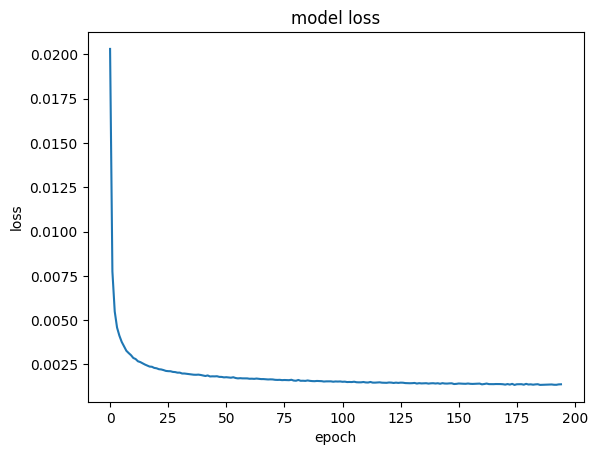

In [38]:
history = model.fit(train_gen, epochs=epochs, steps_per_epoch=num_steps_per_epoch, callbacks=[early_stopping])

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [41]:
# model.save_weights('./train_14_01_19_58_195_triple_convs_UNet.h5')

# An important note on Generalization
I noted that, in all the aforementioned experiments on my different architectures, my models never showed signs of overfitting. I suppose that this is mainly due to two factors: the first being that <em>all</em> the MNIST images share some common characteristics (e.g. the digits are more or less always in the center of the image and are also about the same size), and so the validation set and the train set are not so different. The second, and this is in my opinion the most important of the two, is that the generators that we use to generate our data apply ten <b>random</b> transformations to the images they extract in order to create the blurred samples: this means that everytime an image is extracted a new (and with all probability different from the last time the same image has been extracted) sample will be created. This is a <b>very strong form of regularization</b> in itself since we are basically performing data augmentation <em>on every single sample</em>. For said reasons, apart from using a small batch size coupled with a small learning rate (3e-4), i've not employed other forms of regularization, since i did not think it was necessary.    

# Visual quality of our model predictions - Training Set

### Example #1

    Blurred image and Ground Truth:

10


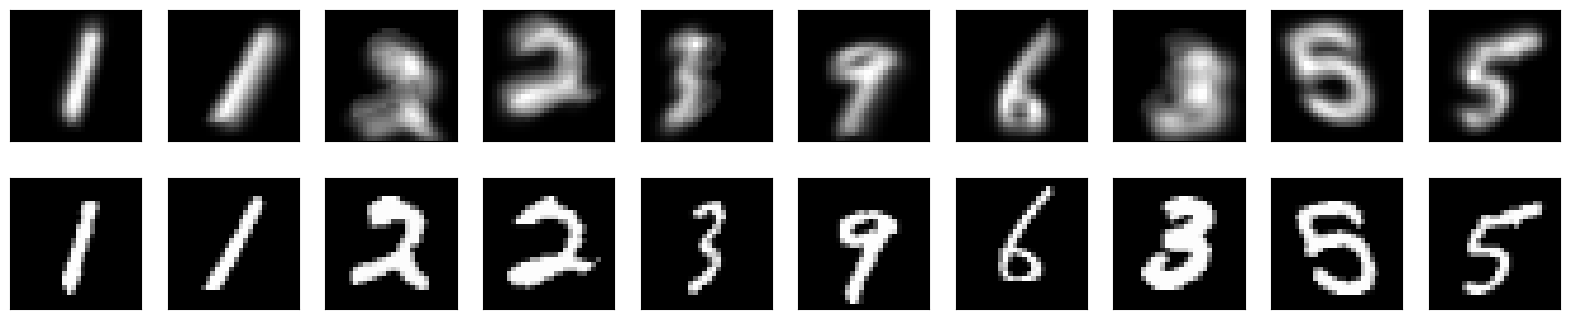

In [42]:
true_blurred_img, true_image = next(train_gen)
plot(true_blurred_img[:10], true_image[:10])

    Blurred image and Model Prediction:

1/1 [==============================] - 0s 319ms/step
10


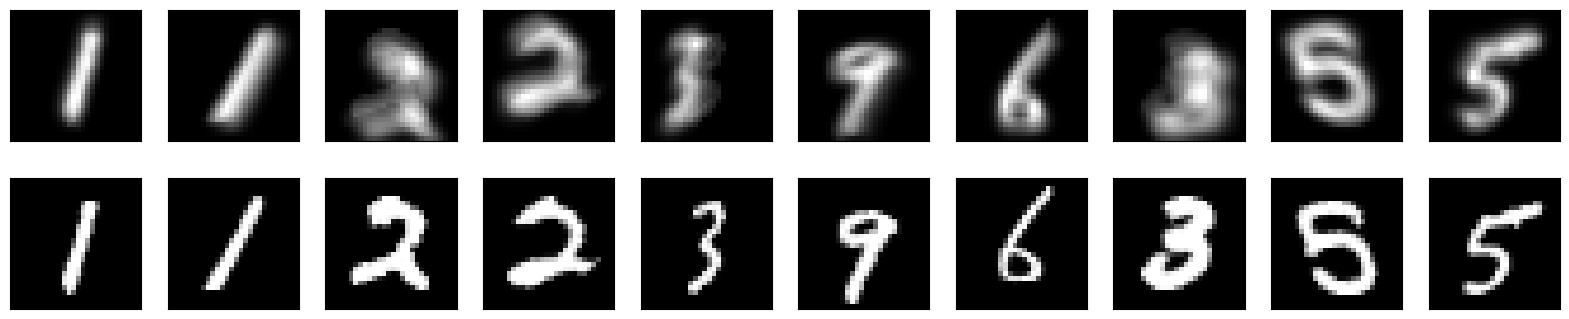

In [43]:
pred_img = model.predict(true_blurred_img)
plot(true_blurred_img[:10], pred_img[:10])

    Ground Truth VS Model Prediction:

10


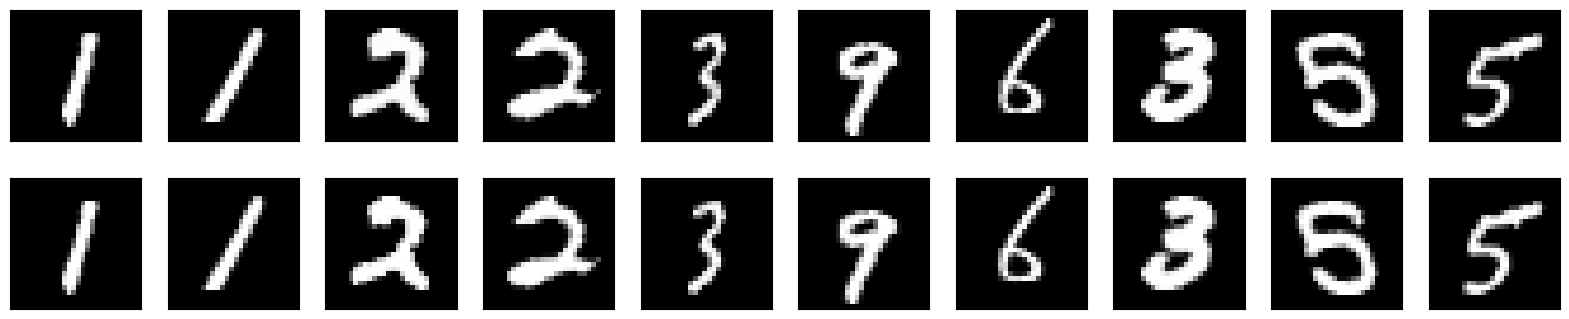

In [44]:
plot(true_image[:10], pred_img[:10])

### Example #2

    Blurred image and Ground Truth:

10


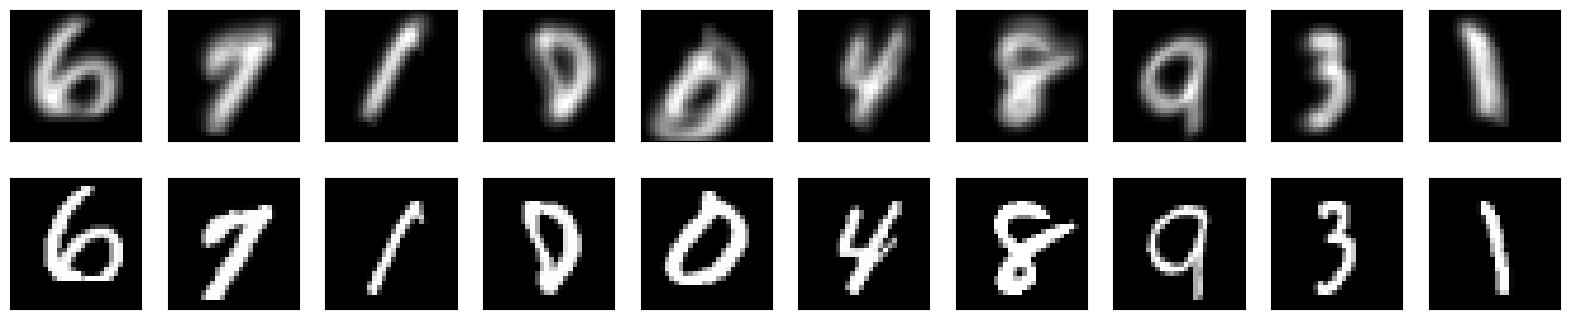

In [45]:
true_blurred_img, true_image = next(train_gen)
plot(true_blurred_img[:10], true_image[:10])

    Blurred image and Model Prediction:

1/1 [==============================] - 0s 40ms/step
10


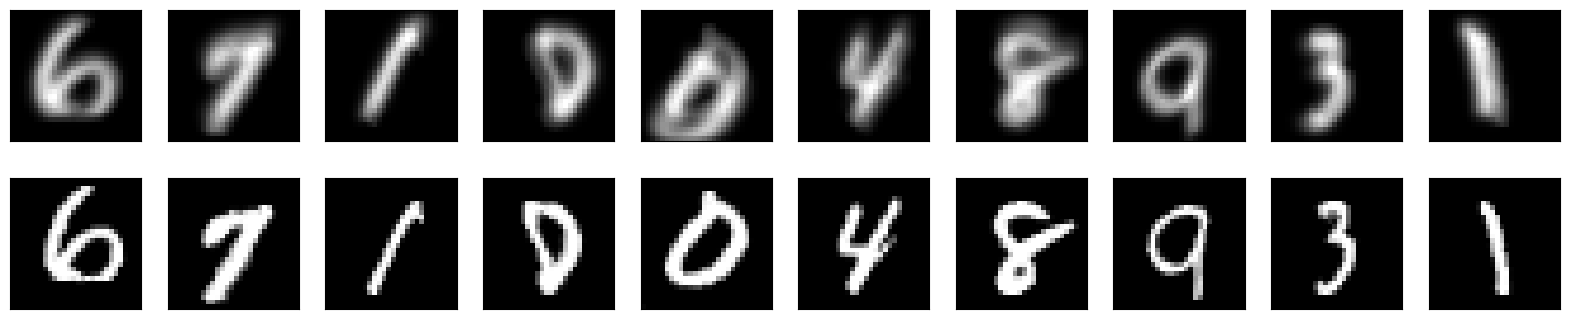

In [46]:
pred_img = model.predict(true_blurred_img)
plot(true_blurred_img[:10], pred_img[:10])

    Ground Truth VS Model Prediction:

10


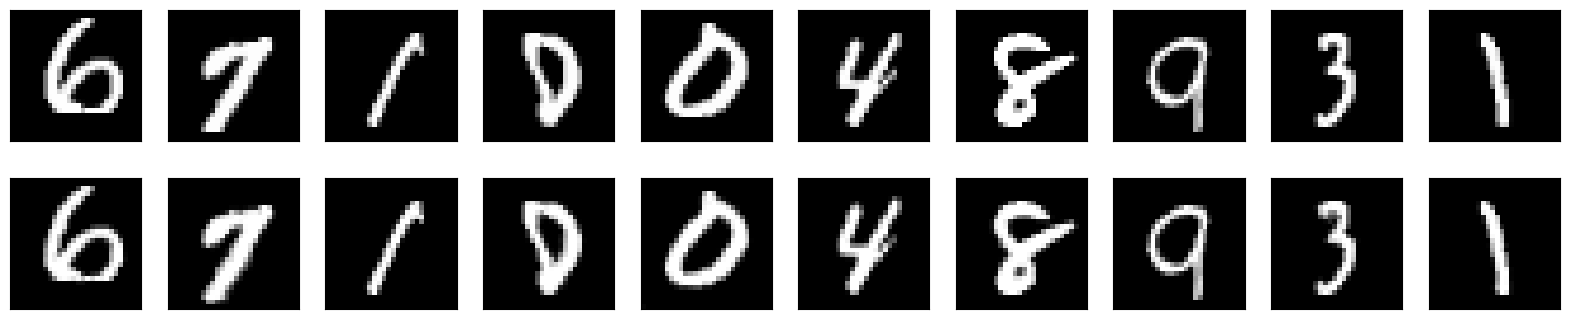

In [47]:
plot(true_image[:10], pred_img[:10])

### Example #3

    Blurred image and Ground Truth:

10


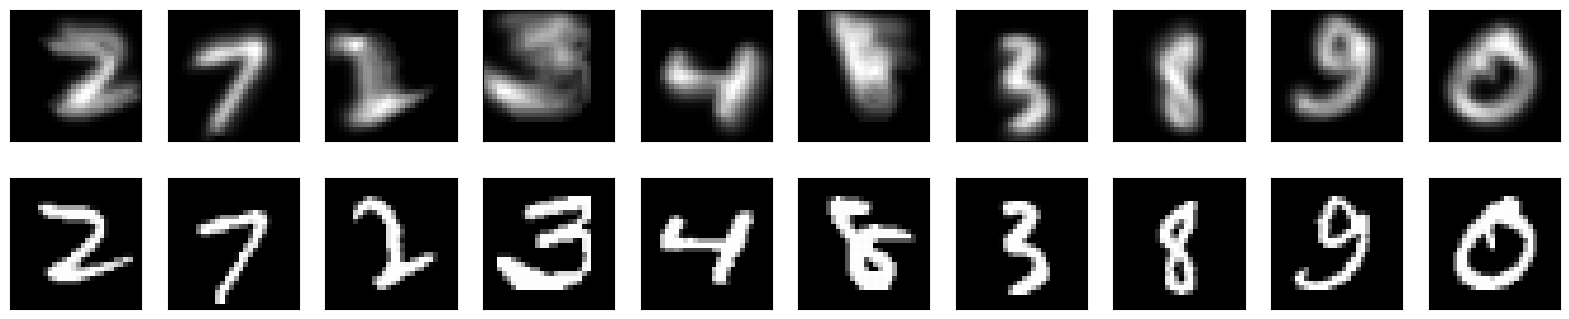

In [48]:
true_blurred_img, true_image = next(train_gen)
plot(true_blurred_img[:10], true_image[:10])

    Blurred image and Model Prediction:

1/1 [==============================] - 0s 35ms/step
10


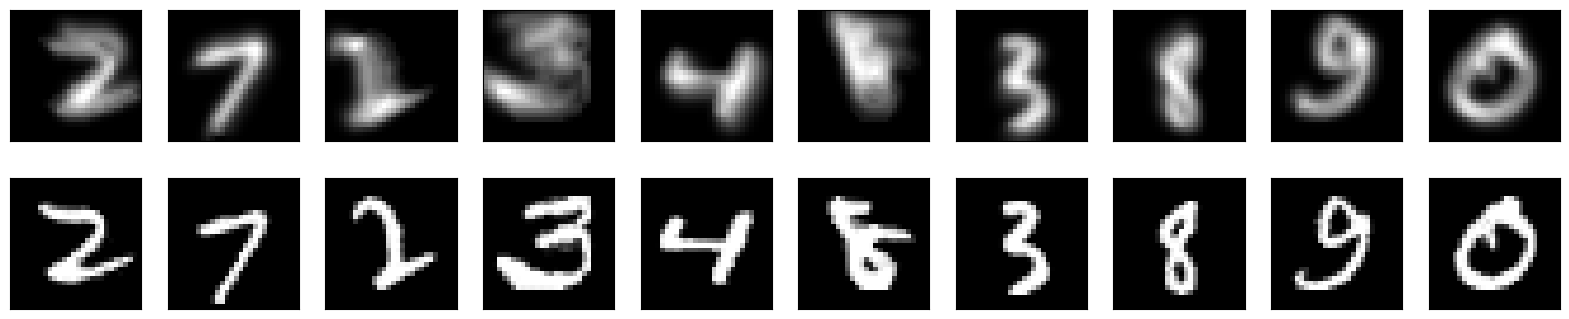

In [49]:
pred_img = model.predict(true_blurred_img)
plot(true_blurred_img[:10], pred_img[:10])

    Ground Truth VS Model Prediction:

10


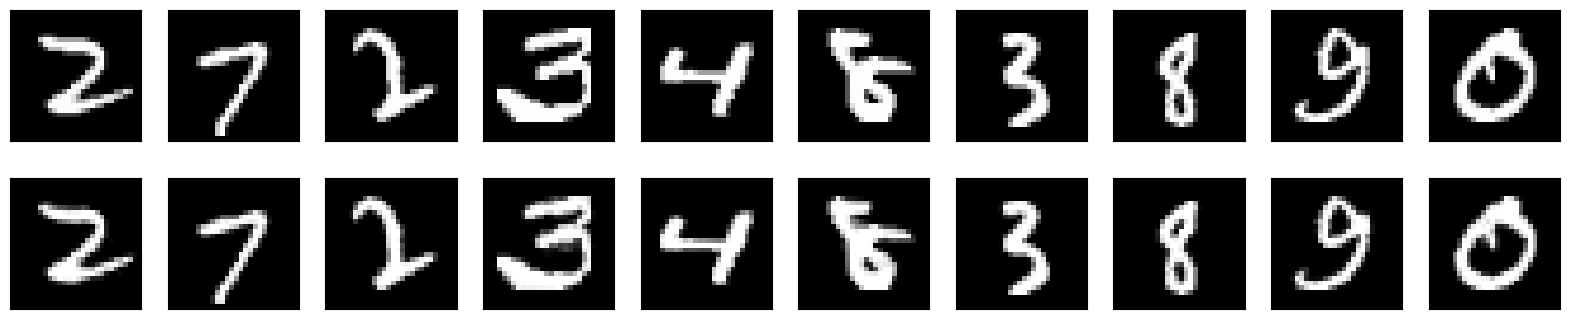

In [50]:
plot(true_image[:10], pred_img[:10])

# Visual quality of our model predictions - Validation Set

### Example #1

    Blurred image and Ground Truth:

10


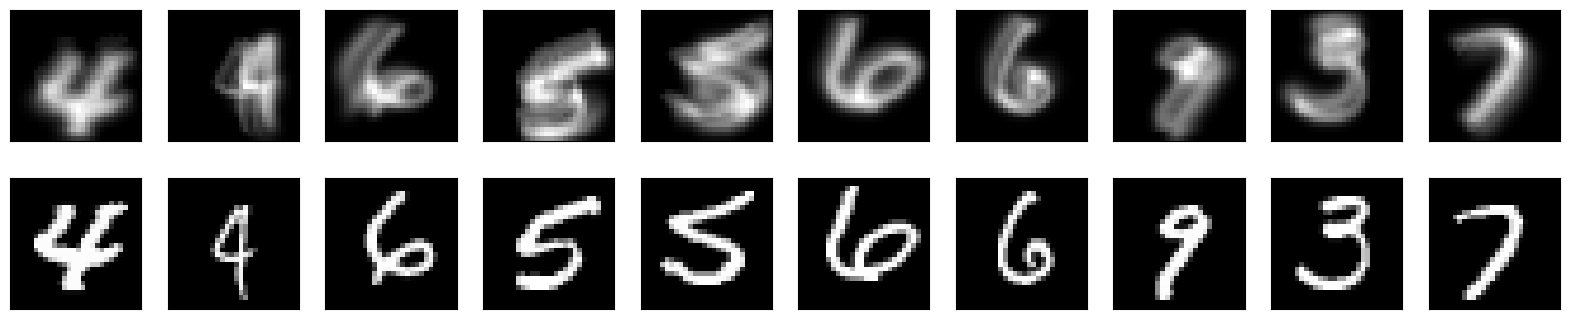

In [51]:
true_blurred_img_val, true_image_val = next(my_validation_gen)
plot(true_blurred_img_val[:10], true_image_val[:10])

    Blurred image and Model Prediction:

2/2 [==============================] - 0s 19ms/step
10


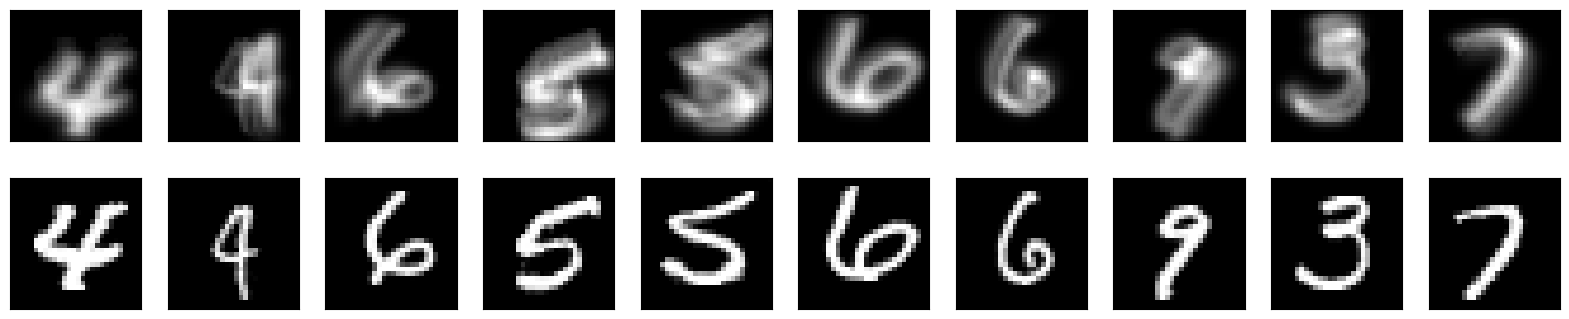

In [52]:
pred_img_val = model.predict(true_blurred_img_val)
plot(true_blurred_img_val[:10], pred_img_val[:10])

    Ground Truth VS Model Prediction:

10


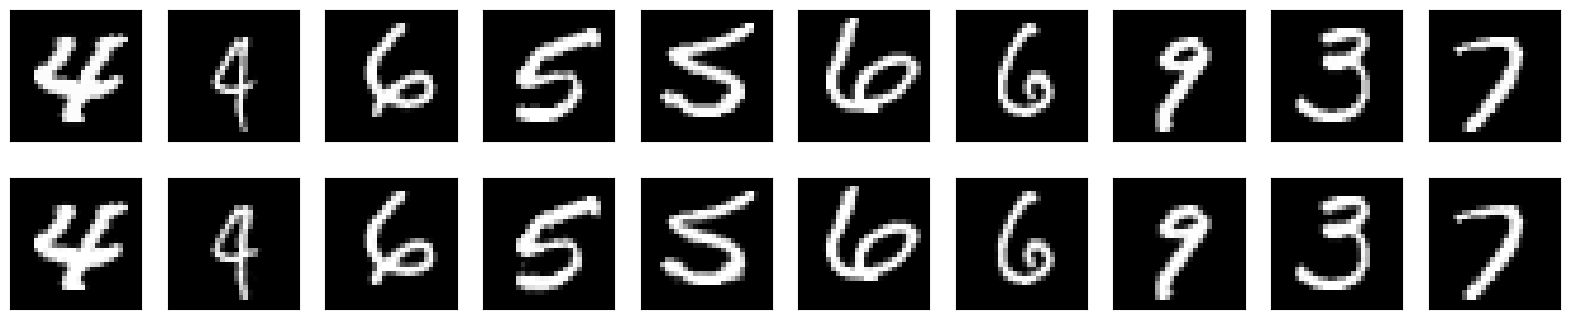

In [53]:
plot(true_image_val[:10], pred_img_val[:10])    

### Example #2

    Blurred image and Ground Truth:

10


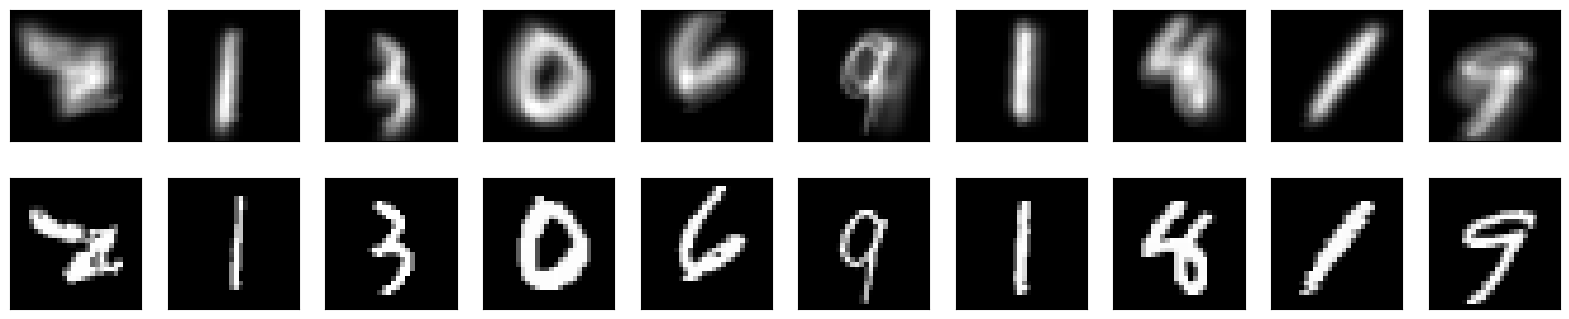

In [54]:
true_blurred_img_val, true_image_val = next(my_validation_gen)
plot(true_blurred_img_val[:10], true_image_val[:10])

    Blurred image and Model Prediction:

2/2 [==============================] - 0s 20ms/step
10


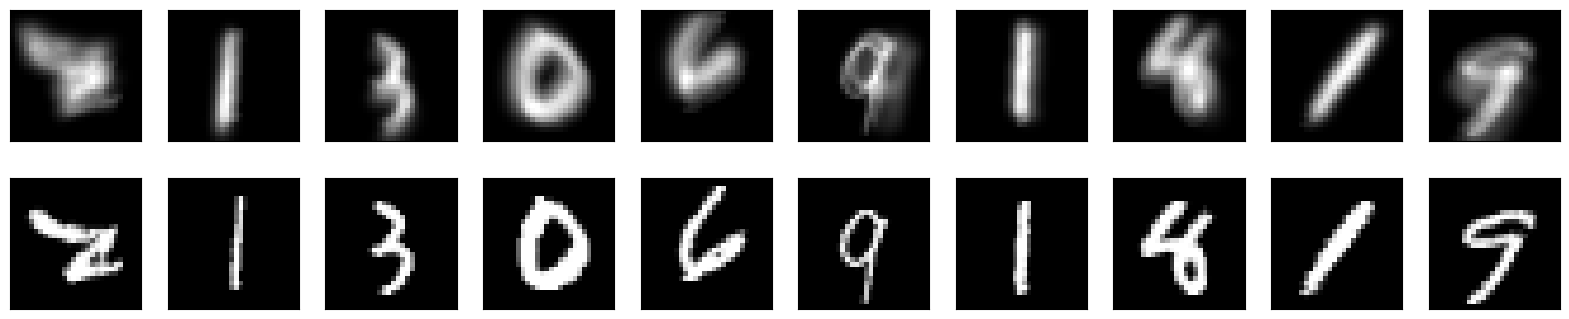

In [55]:
pred_img_val = model.predict(true_blurred_img_val)
plot(true_blurred_img_val[:10], pred_img_val[:10])

    Ground Truth VS Model Prediction:

10


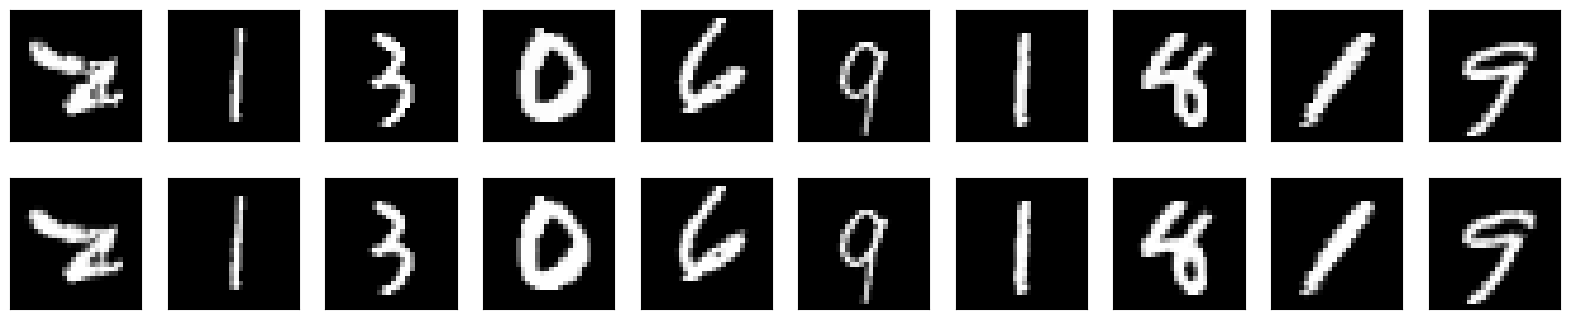

In [56]:
plot(true_image_val[:10], pred_img_val[:10])

### Example #3

    Blurred image and Ground Truth:

10


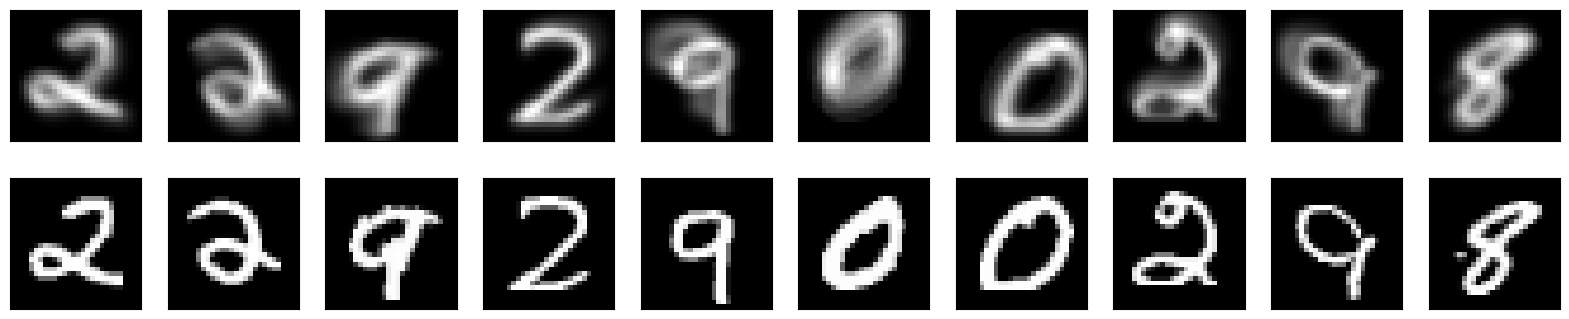

In [57]:
true_blurred_img_val, true_image_val = next(my_validation_gen)
plot(true_blurred_img_val[:10], true_image_val[:10])

    Blurred image and Model Prediction:

2/2 [==============================] - 0s 14ms/step
10


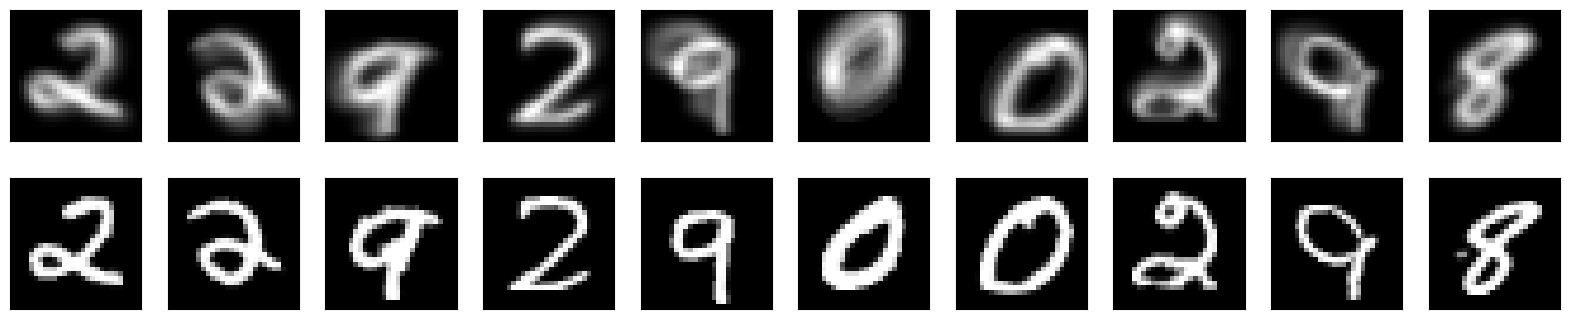

In [58]:
pred_img_val = model.predict(true_blurred_img_val)
plot(true_blurred_img_val[:10], pred_img_val[:10])

    Ground Truth VS Model Prediction:

10


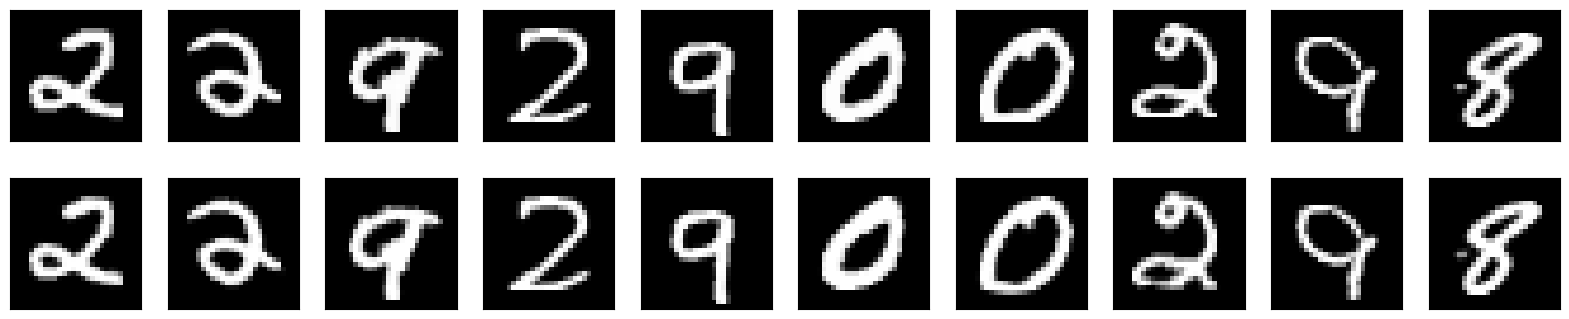

In [59]:
plot(true_image_val[:10], pred_img_val[:10])    

# Final Results

In [60]:
num_rounds = 10
mse_list = []

steps = test_samples // validation_batch_size

for round in range(num_rounds):
    # Evaluating on validation set
    mse = model.evaluate(my_validation_gen, steps = steps)
    mse_list.append(mse)

# Calculating mean and standard deviation of MSE
mean_mse = np.mean(mse_list)
std_mse = np.std(mse_list)

print()
print(f'Mean MSE over 10 rounds: {mean_mse}')
print(f'Standard Deviation of MSE over 10 rounds: {std_mse}')


200/200 [==============================] - 17s 85ms/step - loss: 0.0013

Mean MSE over 10 rounds: 0.0013373994966968893
Standard Deviation of MSE over 10 rounds: 1.867195579194252e-05


# Final results:
# Mean MSE over 10 rounds: 0.0013373994966968893
# Standard Deviation of MSE over 10 rounds: 1.867195579194252e-05